In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> State propagation </h1>

In [2]:
def propagate_state(c_init,b1_init,b2_init, g_0,omega_tab_p,omega_A,L,T,dt, print_info=False):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c_init (np array): Coefficients in front of the states |1_k1, 1_k2, 0>
    b_init (np array): Atomic coefficient in front of the state |1_k, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    state_list: list of states
    """

    ##first, create the Hamiltonian
    n_modes = len(omega_tab_p)
    omega_tab = np.concatenate((omega_tab_p, omega_tab_p))
    dim_subspace = 4*n_modes**2 + 2*n_modes + 2*n_modes
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    if print_info:
        print("Dim subspace = ", dim_subspace,". Creating the Hamiltonian ...")

    #Action on states |k_1, k_2, g>
    dummy_index_0 = 0
    for i in range(2*n_modes):
        for j in range(2*n_modes):
            H_matrix[dummy_index_0, dummy_index_0] = omega_tab[i] + omega_tab[j]

            dummy_index_1 = 4*n_modes**2
            for l in range(2*n_modes):
                if l == i:
                    H_matrix[dummy_index_1, dummy_index_0] = 1j*g_0*np.sqrt(omega_A/L)
                dummy_index_1 += 1
            
            for l in range(2*n_modes):
                if l == j:
                    H_matrix[dummy_index_1, dummy_index_0] = 1j*g_0*np.sqrt(omega_A/L)
                dummy_index_1 += 1    
            
            dummy_index_0 += 1
    
    #Action on states |k_1, 0, e>
    for i in range(2*n_modes):
        H_matrix[dummy_index_0, dummy_index_0] = omega_tab[i] + omega_A

        dummy_index_1 = 0
        for l in range(2*n_modes):
            for m in range(2*n_modes):
                if l == i:
                    H_matrix[dummy_index_1, dummy_index_0] = -1j*g_0*np.sqrt(omega_A/L)
                dummy_index_1 += 1
        
        dummy_index_0 += 1
    
    #Action on states |0, k_2, e>
    for i in range(2*n_modes):
        H_matrix[dummy_index_0, dummy_index_0] = omega_tab[i] + omega_A

        dummy_index_1 = 0
        for l in range(2*n_modes):
            for m in range(2*n_modes):
                if m == i:
                    H_matrix[dummy_index_1, dummy_index_0] = -1j*g_0*np.sqrt(omega_A/L)
                dummy_index_1 += 1
        
        dummy_index_0 += 1

    H = qt.Qobj(H_matrix)
    #sanity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None

    if print_info:
        print("Converting the initial state for QuTip ...")
    ##Now prepare the initial state and run the evolution
    init_state = 0
    dummy_index = 0
    for a in range(2*n_modes):
        for b in range(2*n_modes):
            init_state += c_init[a,b] * qt.basis(dim_subspace, dummy_index)
            dummy_index += 1

    for l in range(2*n_modes):
        init_state += b1_init[l] * qt.basis(dim_subspace, dummy_index)
        dummy_index += 1
    
    for l in range(2*n_modes):
        init_state += b2_init[l] * qt.basis(dim_subspace, dummy_index)
        dummy_index += 1

    if print_info:
        print("Starting the propagation ...")
    ##Run the evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states

    return state_list


<h1> Function that treats the whole evolution </h1>

In [3]:
def get_data_bs_ed(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = False, progress_bar=True):
    """
    Generate data for the RG scheme with a beamsplitter.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atom
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the first Gaussian peak.
    x_1 (float): Position of the second Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k1, 1_k2, 0>.
    b_array (np array): Coefficients in front of the state |1_k, 1>.
    overlap_tab (np array): Array of overlaps with the initial state.
    """
    
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab_individual = np.copy(omega_tab_p) #only positive modes
    n_modes = len(k_tab_individual) #number of modes in each waveguide

    if print_info:
        print("Number of modes: ", n_modes)
    
    #prepare the initial state
    if print_info:
        print("Preparing the initial state...")
    c_init = np.zeros((2*n_modes, 2*n_modes), dtype=complex)
    b1_init = np.zeros(2*n_modes, dtype=complex)
    b2_init = np.zeros(2*n_modes, dtype=complex)


    c_a_individual = np.exp(-0.5*sigma**2*(k_tab_individual - omega_0)**2 -1j * k_tab_individual * x_0)
    c_a = np.concatenate((c_a_individual, np.zeros(n_modes))) #put it in the first waveguide

    c_b_individual = np.exp(-0.5*sigma**2*(k_tab_individual - omega_0)**2 -1j * k_tab_individual * x_1)
    c_b = np.concatenate((np.zeros(n_modes), c_b_individual)) #put it in the second waveguide

    c_init = c_a[:, np.newaxis] * c_b[np.newaxis, :]
    c_init = (c_init + c_init.T)
    norm = np.sqrt(np.sum(np.abs(c_init)**2))
    c_init /= norm

    ##evolve the state
    if print_info:
        print("Evolving the state...")
    state_list = propagate_state(c_init,b1_init,b2_init,g_0,omega_tab_p,omega_A,L,T,dt, print_info=print_info)


    return state_list, k_tab_individual

<h1> First test </h1>

Some checks

In [4]:
L = 10*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.5
omega_A = 2
omega_max = 5

omega_A_phys = 10
g_0_phys = 0.538

omega_0 = omega_A_phys + 1*g_0_phys**2 * omega_A_phys 

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma

x_0 = -L/4
delta_x = 0*sigma
x_1 = x_0 + delta_x

#check some parameters
gamma = g_0**2 * omega_A
print("50% Reflectivity for omega_0_m = ", omega_A - gamma, " and omega_0_p = ", omega_A + gamma)
print("omega_0 = ", omega_0)
print("Physical bandwith is ", g_0_phys**2 * omega_A_phys, " and sigma momentum is ", sigma_momentum)

50% Reflectivity for omega_0_m =  1.5  and omega_0_p =  2.5
omega_0 =  12.89444
Physical bandwith is  2.8944400000000003  and sigma momentum is  0.5092958178940651


Run the calculations

In [5]:
state_list, k_tab_individual = get_data_bs_ed(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = True, progress_bar=True)

Number of modes:  26
Preparing the initial state...
Evolving the state...
Dim subspace =  2808 . Creating the Hamiltonian ...
Converting the initial state for QuTip ...
Starting the propagation ...
10.0%. Run time:   0.24s. Est. time left: 00:00:00:02
20.0%. Run time:   0.44s. Est. time left: 00:00:00:01
30.0%. Run time:   0.67s. Est. time left: 00:00:00:01
40.0%. Run time:   0.89s. Est. time left: 00:00:00:01
50.0%. Run time:   1.14s. Est. time left: 00:00:00:01
60.0%. Run time:   1.36s. Est. time left: 00:00:00:00
70.0%. Run time:   1.60s. Est. time left: 00:00:00:00
80.1%. Run time:   1.87s. Est. time left: 00:00:00:00
90.1%. Run time:   2.14s. Est. time left: 00:00:00:00
100.0%. Run time:   2.42s. Est. time left: 00:00:00:00
Total run time:   2.42s


<h1> Coherence and atom excitation </h1>

In [6]:
time_array = np.linspace(0, T, int(T / dt))
nb_pts_time = int(T / dt)
n_modes = len(k_tab_individual)

c_11 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
c_12 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
c_21 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
c_22 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)

p_11 = np.zeros(nb_pts_time)
p_12 = np.zeros(nb_pts_time)
p_21 = np.zeros(nb_pts_time)
p_22 = np.zeros(nb_pts_time)

atom_excitation = np.zeros(nb_pts_time)
#get the number of modes

for i in tqdm(range(nb_pts_time)):
    current_state = state_list[i].full()
    c_current = current_state[:4*n_modes**2].reshape((2*n_modes, 2*n_modes))
    b1_current = current_state[4*n_modes**2:4*n_modes**2 + 2*n_modes].reshape(2*n_modes)
    b2_current = current_state[4*n_modes**2 + 2*n_modes:].reshape(2*n_modes)

    c_11[i] = c_current[:n_modes, :n_modes]
    c_12[i] = c_current[:n_modes, n_modes:]
    c_21[i] = c_current[n_modes:, :n_modes]
    c_22[i] = c_current[n_modes:, n_modes:]

    atom_excitation[i] = np.sum(np.abs(b1_current)**2) + np.sum(np.abs(b2_current)**2)
    p_11[i] = np.sum(np.abs(c_11[i])**2)
    p_12[i] = np.sum(np.abs(c_12[i])**2)
    p_21[i] = np.sum(np.abs(c_21[i])**2)
    p_22[i] = np.sum(np.abs(c_22[i])**2)

  0%|          | 0/1570 [00:00<?, ?it/s]

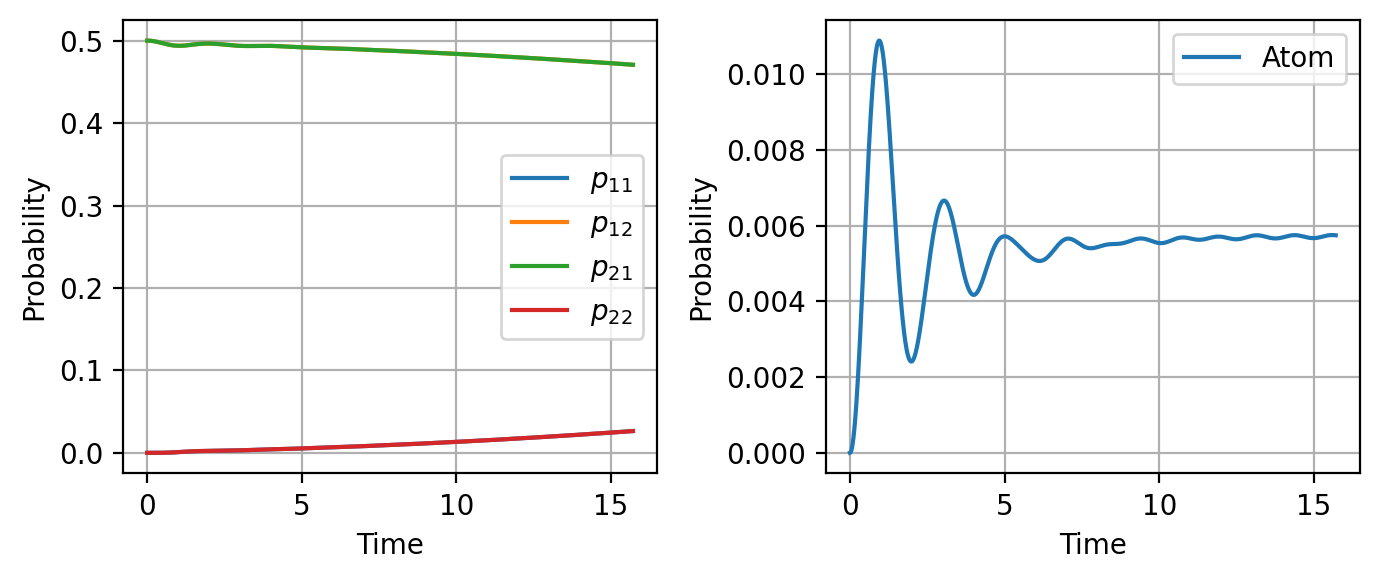

In [7]:
fig, ax = plt.subplots(1,2, figsize=(7,3), dpi=resol)

ax[0].plot(time_array, p_11, label="$p_{11}$")
ax[0].plot(time_array, p_12, label="$p_{12}$")
ax[0].plot(time_array, p_21, label="$p_{21}$")
ax[0].plot(time_array, p_22, label="$p_{22}$")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Probability')
ax[0].legend()
ax[0].grid()
#ax[0].set_ylim([0,0.55])


ax[1].plot(time_array, atom_excitation,label='Atom')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Probability')
ax[1].legend()
ax[1].grid()
#ax[1].set_ylim([0,0.55])

fig.tight_layout()
plt.show()

Sanity check : HOM effect

In [21]:
#print("Final overlap: ", overlap_tab[-1])
print("anti HOM probability ", 1 - p_11[-1] - p_22[-1])
#print("Sanity check ", p_12[-1] + p_21[-1])
print("Theorytical value: ", 0.5 * (1 - np.exp(-0.5 * (np.abs(x_0 - x_1) / sigma)**2)))

anti HOM probability  0.07666588897496013
Theorytical value:  0.0


Visualize wave function in both channels

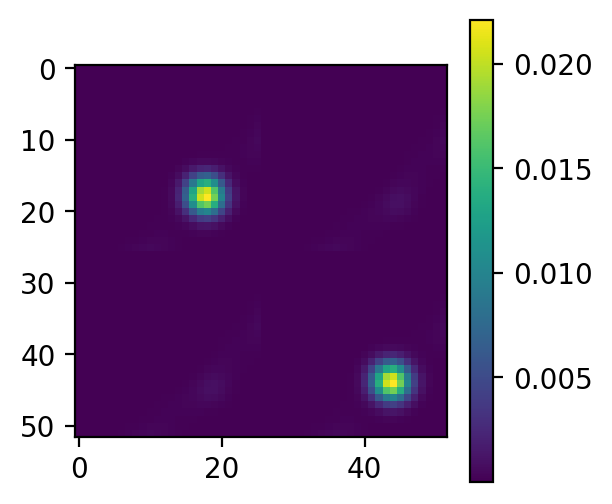

In [22]:
time_index = -1
current_state = state_list[time_index]
c_current = current_state[:4*n_modes**2].reshape((2*n_modes, 2*n_modes))
#c_current = c_current[:n_modes, :n_modes]
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
im = ax.imshow(np.abs(c_current)**2)
plt.colorbar(im, ax=ax)
plt.show()